In [2]:
import sys
sys.path.append("..")
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from coh_tools import *
%matplotlib inline

/home/julien/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Get experiment info
os.chdir("/home/julien/school/lab/oe_data_analysis/csvs")
# os.chdir(r"C:\Users\julienb\lab\oe_data_analysis\csvs")
experiments = pd.read_csv('table_of_experiments.csv')
experiments['keyname'] = experiments['File Name'].str[:-4]

In [4]:
experiments

Experiment   Monkey  YYYYMMDD   Session PREAMP  \
0    Experiment1  MonkeyG  20150908  Session2     M1   
1    Experiment2  MonkeyG  20150908  Session3     M1   
2    Experiment3  MonkeyG  20150908  Session4     M1   
3    Experiment4  MonkeyG  20150909  Session2     M1   
4    Experiment5  MonkeyG  20150909  Session3     M1   
5    Experiment6  MonkeyG  20150909  Session4     M1   
6    Experiment7  MonkeyG  20150909  Session5     M1   
7    Experiment8  MonkeyG  20150910  Session3     S1   
8    Experiment9  MonkeyG  20150910  Session4     S1   
9   Experiment10  MonkeyG  20150910  Session6     S1   
10  Experiment11  MonkeyG  20150910  Session7     S1   
11  Experiment12  MonkeyG  20150911  Session2     S1   
12  Experiment13  MonkeyG  20150911  Session3     S1   
13  Experiment14  MonkeyG  20150911  Session4     S1   
14  Experiment15  MonkeyG  20150911  Session5     S1   
15  Experiment16  MonkeyG  20150911  Session6     S1   
16  Experiment17  MonkeyG  20150911  Session7     S1   
17  Experiment18  MonkeyG  20150914  Session1     S1   
18  Experiment19  MonkeyG  20150914  Session2     S1   
19  Experiment20  MonkeyG  20150914  Session3     S1   
20  Experiment21  MonkeyG  20150915  Session2     S1   
21  Experiment22  MonkeyG  20150915  Session3     S1   
22  Experiment23  MonkeyG  20150915  Session4     S1   
23  Experiment24  MonkeyG  20150915  Session5     S1   
24  Experiment25  MonkeyG  20150916  Session4     S1   
25  Experiment26  MonkeyG  20150917  Session1     M1   
26  Experiment27  MonkeyG  20150917  Session1     S1   
27  Experiment28  MonkeyG  20150917  Session2     M1   
28  Experiment29  MonkeyG  20150917  Session2     S1   
29  Experiment30  MonkeyG  20150917  Session3     M1   
..           ...      ...       ...       ...    ...   
39  Experiment40  MonkeyG  20150925  Session2     S1   
40  Experiment41  MonkeyJ  20160425  Session1     M1   
41  Experiment42  MonkeyJ  20160425  Session2     M1   
42  Experiment43  MonkeyJ  20160425  Session3     S1   
43  Experiment44  MonkeyJ  20160426  Session1     S1   
44  Experiment45  MonkeyJ  20160426  Session2     S1   
45  Experiment46  MonkeyJ  20160426  Session3     S1   
46  Experiment47  MonkeyJ  20160427  Session2     S1   
47  Experiment48  MonkeyJ  20160428  Session2     S1   
48  Experiment49  MonkeyJ  20160428  Session3     S1   
49  Experiment50  MonkeyJ  20160429  Session1     S1   
50  Experiment51  MonkeyJ  20160429  Session3     S1   
51  Experiment52  MonkeyJ  20160502  Session1     S1   
52  Experiment53  MonkeyJ  20160624  Session1     S1   
53  Experiment54  MonkeyJ  20160624  Session2     S1   
54  Experiment55  MonkeyJ  20160624  Session3     S1   
55  Experiment56  MonkeyJ  20160624  Session4     S1   
56  Experiment57  MonkeyJ  20160625  Session2     S1   
57  Experiment58  MonkeyJ  20160625  Session3     S1   
58  Experiment59  MonkeyJ  20160625  Session4     S1   
59  Experiment60  MonkeyJ  20160625  Session5     S1   
60  Experiment61  MonkeyJ  20160626  Session1     S1   
61  Experiment62  MonkeyJ  20160626  Session2     S1   
62  Experiment63  MonkeyJ  20160626  Session3     S1   
63  Experiment64  MonkeyJ  20160627  Session1     S1   
64  Experiment65  MonkeyJ  20160627  Session2     S1   
65  Experiment66  MonkeyJ  20160630  Session1     S1   
66  Experiment67  MonkeyJ  20160630  Session3     S1   
67  Experiment68  MonkeyJ  20160702  Session2     S1   
68  Experiment69  MonkeyJ  20160702  Session4     S1   

                           File Name  stim_Coh_from  stim_Coh_to  \
0   MonkeyG_20150908_Session2_M1.zip             46           63   
1   MonkeyG_20150908_Session3_M1.zip             48           43   
2   MonkeyG_20150908_Session4_M1.zip             48           16   
3   MonkeyG_20150909_Session2_M1.zip             48           12   
4   MonkeyG_20150909_Session3_M1.zip             53           27   
5   MonkeyG_20150909_Session4_M1.zip             46           16   
6   MonkeyG_20150909_Session5_M1.zip             14      

In [5]:
## Load data and get rid of bad channels
multiband_paired_dict = {"beta": {}, "gamma": {}, "high_gamma": {}}

os.chdir("/media/julien/hdd2tb/lab/elife/data/pickled/20sec_allsession_coh")
# os.chdir(r"C:\Users\julienb\lab\data\pickled")
freqs = pkl.load(open("./freqs.pkl", "rb"))

paired_dict = {}

for experiment_i in tqdm(range(len(experiments['keyname']))):
    experiment = experiments['keyname'][experiment_i]
    exp_dict = pkl.load(open(experiment, "rb"))
    stim_from_index = experiments['stim_Coh_from'][experiment_i] - 1
    stim_to_index = experiments['stim_Coh_to'][experiment_i] - 1
    num_las = experiments['Number of Lasers during Conditioning'][experiment_i]
    if (stim_from_index < 0) or (stim_to_index < 0) or (num_las < 2):
        print(experiment, " was not paired stim.")
        continue
    for block_key in exp_dict.keys():
        block = exp_dict[block_key]
        # get coherence of stimmed sites
        block = block[:, stim_from_index, stim_to_index, :]

        for band in ["beta", "gamma", "high_gamma"]:
            band_range = get_band_range(band)
            ba, bb = get_freq_band_indices(freqs, band_range[0], band_range[1])
            band_data = block[:, ba:bb]
            multiband_paired_dict[band][experiment+"_"+block_key] = band_data.mean(axis=1)

#         ga, gb = get_freq_band_indices(freqs, 30, 55)
#         gcb = block[:, ga:gb]
#         paired_dict[experiment+"_"+block_key] = gcb.mean()
        

MonkeyG_20150911_Session2_S1  was not paired stim.
MonkeyG_20150911_Session3_S1  was not paired stim.
MonkeyG_20150911_Session4_S1  was not paired stim.
MonkeyG_20150911_Session5_S1  was not paired stim.
MonkeyG_20150914_Session2_S1  was not paired stim.
MonkeyJ_20160425_Session1_M1  was not paired stim.
MonkeyJ_20160425_Session2_M1  was not paired stim.
MonkeyJ_20160425_Session3_S1  was not paired stim.
MonkeyJ_20160427_Session2_S1  was not paired stim.
MonkeyJ_20160624_Session1_S1  was not paired stim.
MonkeyJ_20160624_Session2_S1  was not paired stim.
MonkeyJ_20160625_Session2_S1  was not paired stim.
MonkeyJ_20160625_Session3_S1  was not paired stim.
MonkeyJ_20160626_Session1_S1  was not paired stim.
MonkeyJ_20160626_Session2_S1  was not paired stim.
MonkeyJ_20160626_Session3_S1  was not paired stim.



In [4]:
# multiband_paired_dict = pkl.load(open("/home/julien/school/lab/oe_data_analysis/pickled/multiband_paired_dict.pkl", "rb"))


In [7]:
multiband_paired_dict['beta']

{'MonkeyG_20150908_Session2_M1_RecBlock1': array([0.55612538]),
 'MonkeyG_20150908_Session2_M1_RecBlock2': array([0.22887547]),
 'MonkeyG_20150908_Session2_M1_CondBlock1': array([0.53682396, 0.21127573, 0.5273983 , 0.57477854, 0.50652922,
        0.52036822, 0.54533434, 0.57175198, 0.57889946, 0.57017328,
        0.590322  , 0.59710496, 0.60562261, 0.42246612, 0.28155103,
        0.34921918, 0.53578752, 0.38070592, 0.38847046, 0.36333785,
        0.40065366]),
 'MonkeyG_20150908_Session2_M1_RecBlock3': array([0.24101996]),
 'MonkeyG_20150908_Session2_M1_CondBlock2': array([0.34026009, 0.37848437, 0.29734814, 0.32990932, 0.30276337,
        0.30657864, 0.3259609 , 0.38829225, 0.27690851, 0.22868355,
        0.34249755, 0.39653619, 0.50185814, 0.47311312, 0.22008854,
        0.41763889, 0.42616765, 0.47247991, 0.38171467, 0.441533  ,
        0.43430641]),
 'MonkeyG_20150908_Session2_M1_RecBlock4': array([0.28212514]),
 'MonkeyG_20150908_Session2_M1_CondBlock3': array([0.24118095, 0.16966

In [8]:
pkl.dump(multiband_paired_dict, open("/home/julien/school/lab/oe_data_analysis/pickled/multiband_timefreq_paired_dict.pkl", "wb"))


In [6]:
for key in paired_dict.keys():
    print(key)
    print(paired_dict[key])
    print()

In [ ]:
# bc = pkl.load(open("/home/julien/school/lab/oe_data_analysis/pickled/bad_channels.pkl", "rb"))

In [7]:
paired_dict = multiband_paired_dict['gamma']

In [8]:
## Sort mean coherences into experiment type

# Shape of these is (num_laser, rec#). and each element is a list of values
cond_means = [[[], [], [], [], []],
              [[], [], [], [], []],
              [[], [], [], [], []]]
rec_means = [[[], [], [], [], [], []],
             [[], [], [], [], [], []],
             [[], [], [], [], [], []]]
exp_list = []
exp_datas = []
num_las_list = []
no_bc_list = []

# Iterate through experiments
for index, row in experiments.iterrows():
    key = row["keyname"]
    num_las = int(row["Number of Lasers during Conditioning"])
#     if key[:25] not in bc:
#         no_bc_list.append(key[:25])
#         continue
        
    # look at individual experiments
    exp_list.append(key[:25])
    exp_data = []
    num_las_list.append(num_las)

    
    # look at all types of experiments
    try:
        for block_num in range(6):
            rec_key = key+"_RecBlock"+str(block_num+1)
            rec_means[num_las][block_num].append(paired_dict[rec_key])
            exp_data.append(paired_dict[rec_key])

            if block_num != 5:
                cond_key = key+"_CondBlock"+str(block_num+1)
                cond_means[num_las][block_num].append(paired_dict[cond_key])
                exp_data.append(paired_dict[cond_key])

        exp_datas.append(exp_data)
    except:
        continue

In [9]:
cond_means_array = np.zeros((3, 5))
for nl in range(3):
    for recn in range(5):
        cond_means_array[nl, recn] = (np.mean(cond_means[nl][recn]))
        
rec_means_array = np.zeros((3, 6))
for nl in range(3):
    for recn in range(6):
        rec_means_array[nl, recn] = (np.mean(rec_means[nl][recn]))

/home/julien/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/julien/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
plt.subplots(figsize=(10,6))
# plt.title("Average coherence in "+band)    
sns.heatmap(cond_means_array, cmap="inferno_r", annot=True)
plt.show()

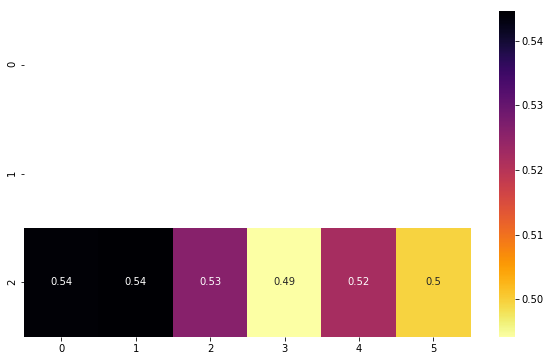

In [11]:
plt.subplots(figsize=(10,6))
# plt.title("Average coherence in "+band)    
sns.heatmap(rec_means_array, cmap="inferno_r", annot=True)
plt.show()

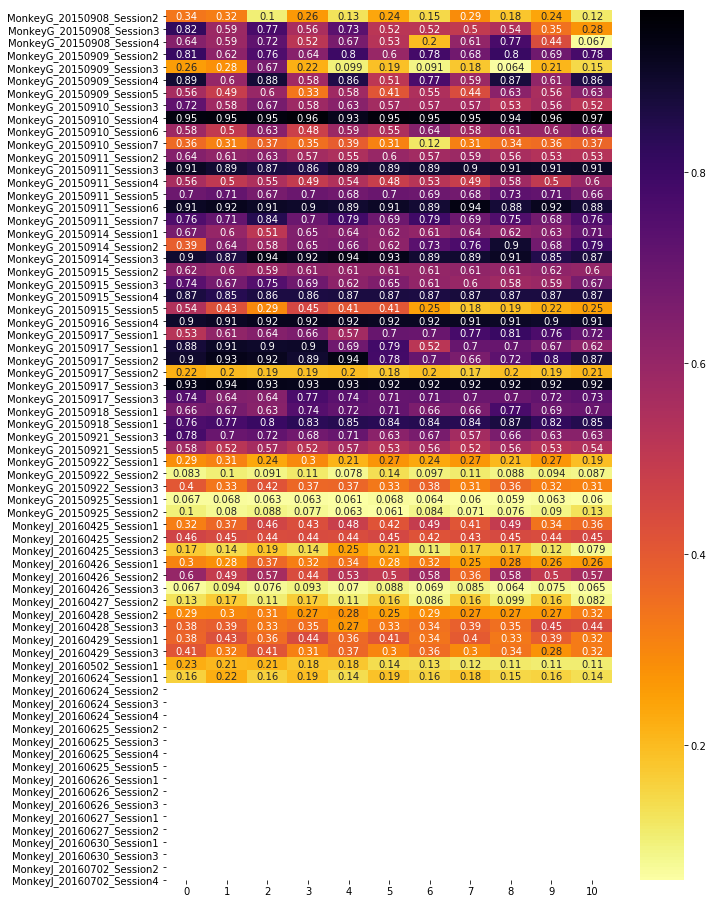

In [12]:
plt.subplots(figsize=(10,16))
# plt.title("Average coherence in "+band)    
sns.heatmap(exp_datas, yticklabels=exp_list, cmap="inferno_r", annot=True)
plt.show()

In [13]:
no_bc_list

[]

In [14]:
"MonkeyG_20150914_Session2" in no_bc_list

False

In [15]:
paired_dict

{'MonkeyG_20150908_Session2_M1_RecBlock1': 0.3359798922364221,
 'MonkeyG_20150908_Session2_M1_RecBlock2': 0.10207238151794829,
 'MonkeyG_20150908_Session2_M1_CondBlock1': 0.32153776640308307,
 'MonkeyG_20150908_Session2_M1_RecBlock3': 0.12884088952852252,
 'MonkeyG_20150908_Session2_M1_CondBlock2': 0.2638910930232893,
 'MonkeyG_20150908_Session2_M1_RecBlock4': 0.14747658403345815,
 'MonkeyG_20150908_Session2_M1_CondBlock3': 0.23800497522411942,
 'MonkeyG_20150908_Session2_M1_RecBlock5': 0.18326525187881773,
 'MonkeyG_20150908_Session2_M1_CondBlock4': 0.2875756341886117,
 'MonkeyG_20150908_Session2_M1_RecBlock6': 0.11503857725432287,
 'MonkeyG_20150908_Session2_M1_CondBlock5': 0.2405045999553834,
 'MonkeyG_20150908_Session3_M1_RecBlock1': 0.8200258549574292,
 'MonkeyG_20150908_Session3_M1_RecBlock2': 0.7709621273826773,
 'MonkeyG_20150908_Session3_M1_CondBlock1': 0.5867521166173205,
 'MonkeyG_20150908_Session3_M1_RecBlock3': 0.7319834378338731,
 'MonkeyG_20150908_Session3_M1_CondBlock2'